In [1]:
import numpy as np      
import pandas as pd
from operator import mul
from matplotlib import pyplot as plt

# Parallel processing comparation between OpenMP, CUDA and MPI
We start by loading the benchmark results into a data frame and aggregating multiple runs by geometric mean

In [5]:
# Declare index structure
col = ("test250", "test500", "test750", "test1", "test1.5", "test2", "test2.5", "test3", "test3.5", "test4", "test4.5")
scol = [str(i) for i in range(1,8)]
mcol = pd.MultiIndex.from_product([col,scol])

row =  ("seq", "omp", "cuda", "mpi", "mpi_br", "cuda_dim")
srow = ("cycles", "real_time_nsec", "PAPI_TOT_INS", "PAPI_TOT_CYC")
mrow = pd.MultiIndex.from_product([row,srow])

row = ("mpi", "mpi_br")
sr_row = ("Send", "Recv")
sr_mrow = pd.MultiIndex.from_product([row, sr_row, srow])

# Recollect data
df = pd.DataFrame(np.loadtxt("results/total_time.csv", delimiter=','), index=mrow, columns=mcol)
sr_df = pd.DataFrame(np.loadtxt("results/mpi_sr_time.csv", delimiter=','), index=sr_mrow, columns=mcol)
pr_df = pd.DataFrame(np.loadtxt("results/predator-seq-results.csv", delimiter=','), index=srow, columns=mcol)

# Compute geometric mean for total cpu time and send/recive time
gmean = pd.DataFrame(np.full((mrow.size, len(col)), np.nan), index=mrow, columns=col)
sr_gmean = pd.DataFrame(np.full((sr_mrow.size, len(col)), np.nan), index=sr_mrow, columns=col)
pr_gmean = pd.DataFrame(np.full((len(srow), len(col)), np.nan), index=srow, columns=col)
for c in col:
    gmean[c] = df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")
    sr_gmean[c] = sr_df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")
    pr_gmean[c] = pr_df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")


gmean.to_excel("results/total_time_geometric_mean.xlsx")
sr_gmean.to_excel("results/mpi_sr_time_geometric_mean.xlsx")
pr_df.to_excel("results/predator-seq-results.xlsx")
pr_gmean.to_excel("results/predator-seq-geometric_mean.xlsx")

# Display geometric mean dataframe
gmean

test250       test500       test750  \
seq      cycles          1.673387e+08  1.400288e+09  5.168005e+09   
         real_time_nsec  5.232133e+07  4.378439e+08  1.615942e+09   
         PAPI_TOT_INS    4.075696e+08  3.255260e+09  1.098058e+10   
         PAPI_TOT_CYC    1.738307e+08  1.451016e+09  5.384591e+09   
omp      cycles          4.444127e+07  3.716906e+08  1.349542e+09   
         real_time_nsec  1.389178e+07  1.162130e+08  4.219572e+08   
         PAPI_TOT_INS    1.061682e+08  8.466837e+08  2.851691e+09   
         PAPI_TOT_CYC    4.347740e+07  3.532998e+08  1.321587e+09   
cuda     cycles          2.916182e+08  5.709952e+08  1.499148e+09   
         real_time_nsec  9.118645e+07  1.785693e+08  4.688333e+08   
         PAPI_TOT_INS    1.377691e+08  8.879972e+08  2.877731e+09   
         PAPI_TOT_CYC    7.518569e+07  4.468246e+08  1.423504e+09   
mpi      cycles          4.757996e+08  1.465509e+09  3.515197e+09   
         real_time_nsec  1.487698e+08  4.582320e+08  1.099129e+09   
         PAPI_TOT_INS    2.018291e+08  6.024138e+08  1.564688e+09   
         PAPI_TOT_CYC    9.586840e+07  3.082886e+08  8.974080e+08   
mpi_br   cycles          3.551366e+08  1.098973e+09  2.648657e+09   
         real_time_nsec  1.110391e+08  3.436221e+08  8.281764e+08   
         PAPI_TOT_INS    4.350385e+08  8.859271e+08  1.828781e+09   
         PAPI_TOT_CYC    1.627402e+08  3.521958e+08  8.881653e+08   
cuda_dim cycles          2.243211e+08  5.750426e+08  1.501570e+09   
         real_time_nsec  7.013842e+07  1.798019e+08  4.695089e+08   
         PAPI_TOT_INS    1.355680e+08  8.871592e+08  2.820509e+09   
         PAPI_TOT_CYC    7.475563e+07  4.464020e+08  1.409520e+09   

                                test1       test1.5         test2  \
seq      cycles          1.433770e+10  6.279546e+10  1.261305e+11   
         real_time_nsec  4.483145e+09  1.963483e+10  3.943876e+10   
         PAPI_TOT_INS    2.602102e+10  8.779729e+10  2.080841e+11   
         PAPI_TOT_CYC    1.499463e+10  6.261429e+10  1.321494e+11   
omp      cycles          3.549884e+09  1.616566e+10  3.267203e+10   
         real_time_nsec  1.109934e+09  5.054658e+09  1.021551e+10   
         PAPI_TOT_INS    6.756734e+09  2.279524e+10  5.402473e+10   
         PAPI_TOT_CYC    3.422319e+09  1.470458e+10  3.189985e+10   
cuda     cycles          3.280228e+09  1.060037e+10  2.481087e+10   
         real_time_nsec  1.025828e+09  3.314976e+09  7.758596e+09   
         PAPI_TOT_INS    6.599040e+09  2.228104e+10  5.399393e+10   
         PAPI_TOT_CYC    3.294044e+09  1.101387e+10  2.597769e+10   
mpi      cycles          6.100154e+09  1.865240e+10  3.770652e+10   
         real_time_nsec  1.907385e+09  5.832204e+09  1.179002e+10   
         PAPI_TOT_INS    3.083125e+09  9.930011e+09  2.255157e+10   
         PAPI_TOT_CYC    1.853989e+09  7.035095e+09  1.522107e+10   
mpi_br   cycles          4.789416e+09  1.539711e+10  3.206241e+10   
         real_time_nsec  1.497546e+09  4.814351e+09  1.002524e+10   
         PAPI_TOT_INS    3.655085e+09  1.062880e+10  2.425053e+10   
         PAPI_TOT_CYC    1.871298e+09  6.492021e+09  1.412671e+10   
cuda_dim cycles          3.281782e+09  1.061658e+10  2.483884e+10   
         real_time_nsec  1.026145e+09  3.319590e+09  7.766610e+09   
         PAPI_TOT_INS    6.529599e+09  2.225264e+10  5.300248e+10   
         PAPI_TOT_CYC    3.259254e+09  1.093097e+10  2.586892e+10   

                              test2.5         test3       test3.5  \
seq      cycles          2.900260e+11  4.165637e+11  9.056659e+11   
         real_time_nsec  9.068526e+10  1.302521e+11  2.831838e+11   
         PAPI_TOT_INS    4.063814e+11  7.021892e+11  1.115008e+12   
         PAPI_TOT_CYC    2.894857e+11  4.365239e+11  9.085283e+11   
omp      cycles          7.747911e+10  1.020482e+11  2.853180e+11   
         real_time_nsec  2.422608e+10  3.190734e+10  8.921292e+10   
         PAPI_TOT_INS    1.055051e+11  1.823011e+11  2.894765e+11   
         PAPI_TOT_CYC    7

The data is structured by the computation technique and tecnology used.

## Comparing speed-ups between the different techniques

# USEFUL

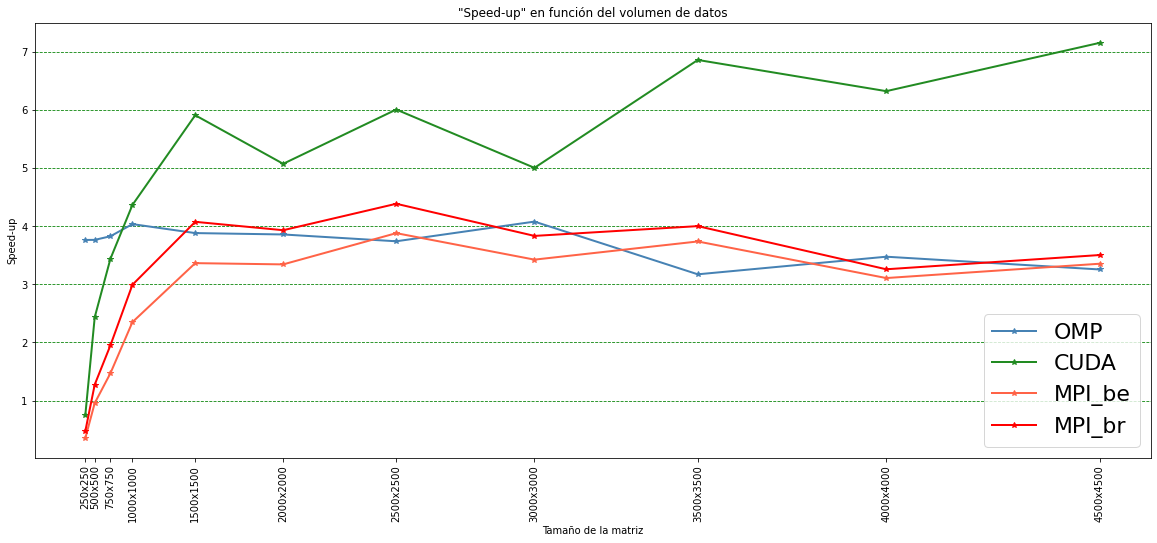

In [27]:
omp_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["omp", "real_time_nsec"])
cuda_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["cuda_dim", "real_time_nsec"])
mpi_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi", "real_time_nsec"])
mpi_br_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi_br", "real_time_nsec"])


real_xaxis = np.array([250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])**2

fig, ax = plt.subplots()

xlabel = ['250x250', '500x500', '750x750', '1000x1000', '1500x1500', '2000x2000', '2500x2500','3000x3000', '3500x3500','4000x4000', '4500x4500']
edgewidth = 2

ax.plot(real_xaxis, omp_sp,'*-', label='OMP', color="steelblue", linewidth=edgewidth)
ax.plot(real_xaxis, cuda_sp, '*-', color="forestgreen", label='CUDA', linewidth=edgewidth)
ax.plot(real_xaxis, mpi_sp, '*-', color="tomato", label='MPI_be', linewidth=edgewidth)
ax.plot(real_xaxis, mpi_br_sp, '*-', color="red", label='MPI_br', linewidth=edgewidth)

ax.set_title("\"Speed-up\" en función del volumen de datos")
ax.set_ylabel("Speed-up")
ax.set_xlabel("Tamaño de la matriz")
ax.set_xticks(real_xaxis)
ax.set_xticklabels(xlabel, rotation=90)
ax.grid(zorder=0, color='green', linestyle='--', axis='y')
ax.legend(fontsize=22)

fig.set_size_inches((20, 8))

# MAYBE USEFUL

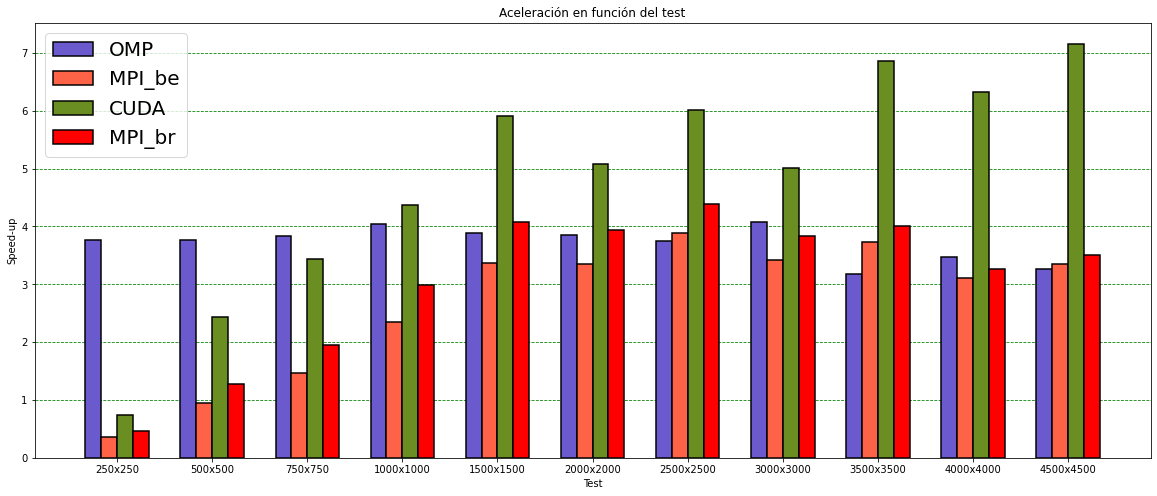

In [64]:
fig, ax = plt.subplots()

xaxis = np.arange(1, len(xlabel)*1.50+1, 1.50)
width = 0.25
edgewidth = 1.5

ax.bar(xaxis - 1.5*width, omp_sp, width,label='OMP', color='slateblue', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis - width/2, mpi_sp, width, color="tomato", label='MPI_be', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width/2, cuda_sp, width, color="olivedrab", label='CUDA', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + 1.5*width, mpi_br_sp, width,color='red', label='MPI_br', edgecolor='black', linewidth=edgewidth)

ax.set_title("Aceleración en función del test")
ax.set_ylabel("Speed-up")
ax.set_xlabel("Test")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=20)
ax.set_axisbelow(True)
ax.grid(zorder=0, color='green', linestyle='--', axis='y')

fig.set_size_inches((20,8))

plt.show()

# TO BE INCLUDED (TALKING ABOUT PARALLELISM EFICIENCY)

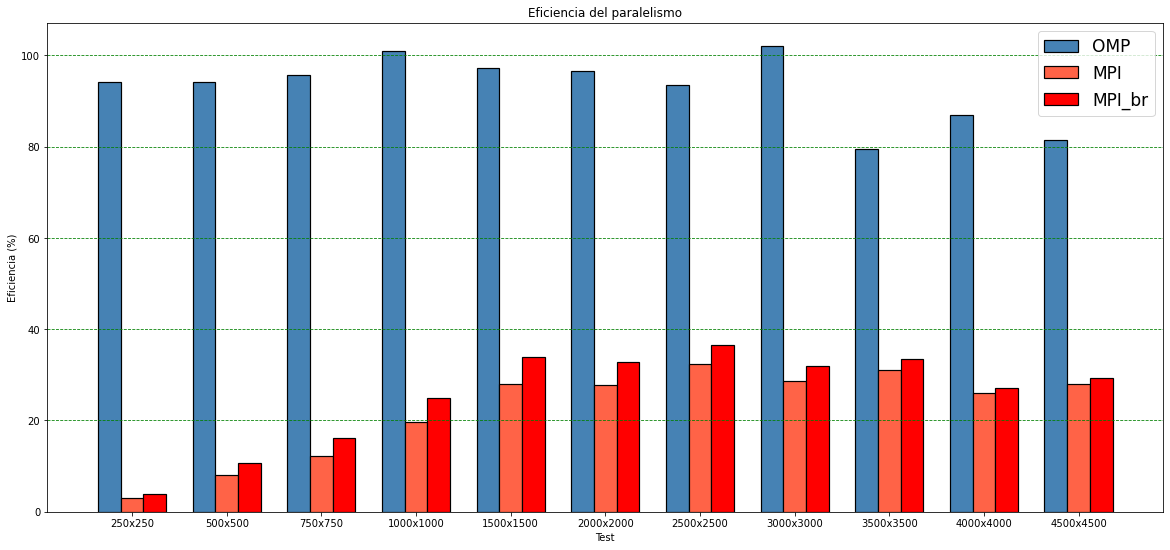

In [22]:
omp_cores = 4
mpi_cores = 12

omp_ef =    100*omp_sp/omp_cores
mpi_ef =    100*mpi_sp/mpi_cores
mpi_br_ef = 100*mpi_br_sp/mpi_cores

fig, ax = plt.subplots()

width = 0.3

ax.bar(xaxis - width, omp_ef, width,label='OMP', color="steelblue", edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis , mpi_ef, width, color="tomato", label='MPI', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width, mpi_br_ef, width, color="red", label='MPI_br', edgecolor='black', linewidth=edgewidth)

ax.set_title("Eficiencia del paralelismo")
ax.set_ylabel("Eficiencia (%)")
ax.set_xlabel("Test")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=17)
ax.grid(color='green', axis='y', linestyle='--')

fig.set_size_inches((20,9))

plt.show()


# COMPARACIÓN ENTRE EL TIEMPO DE ENVÍO DE POR FILAS Y POR ELEMENTOS (MATRIZ ENTERA)

VERY USEFUL AND INTERESTING

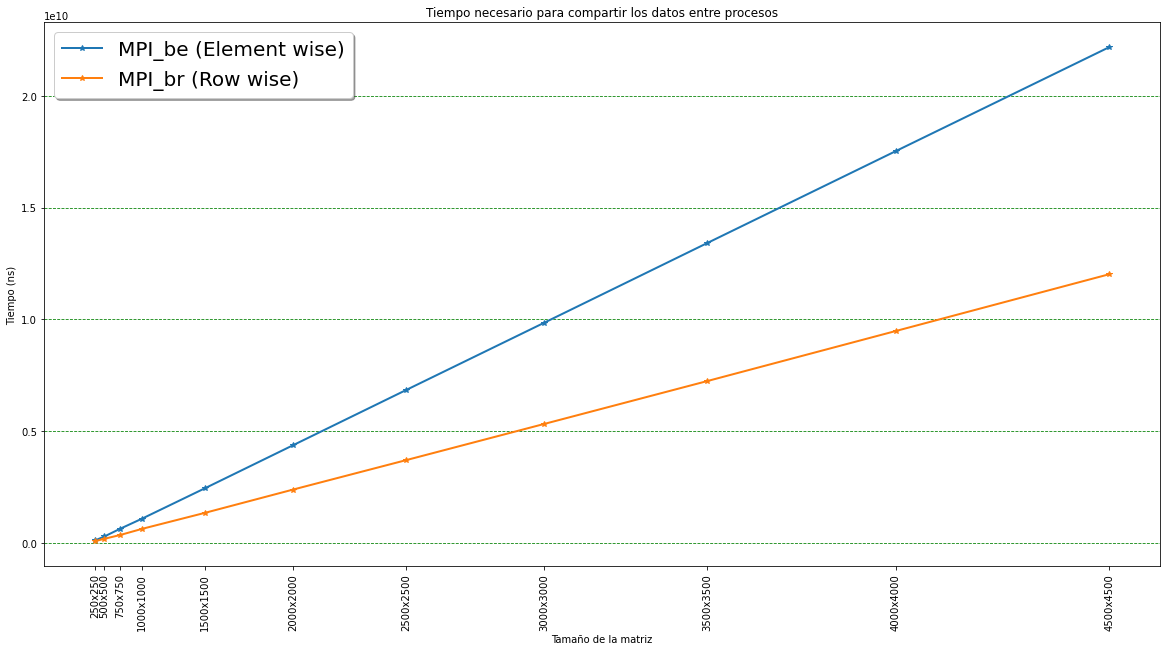

In [74]:
st = sr_gmean.loc["mpi", "Send", "real_time_nsec"]
st_br = sr_gmean.loc["mpi_br", "Send", "real_time_nsec"]

edgewidth=2

fig, ax = plt.subplots()
ax.plot(real_xaxis, st, '*-', label='MPI_be (Element wise)', linewidth=edgewidth)
ax.plot(real_xaxis, st_br, '*-', label='MPI_br (Row wise)', linewidth=edgewidth)

ax.set_title("Tiempo necesario para compartir los datos entre procesos")
ax.set_ylabel("Tiempo (ns)")
ax.set_xlabel("Tamaño de la matriz")
ax.set_xticklabels(xlabel, rotation=90)
ax.set_xticks(real_xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)
ax.grid(color='green', axis='y', linestyle='--')


fig.set_size_inches((20,10))

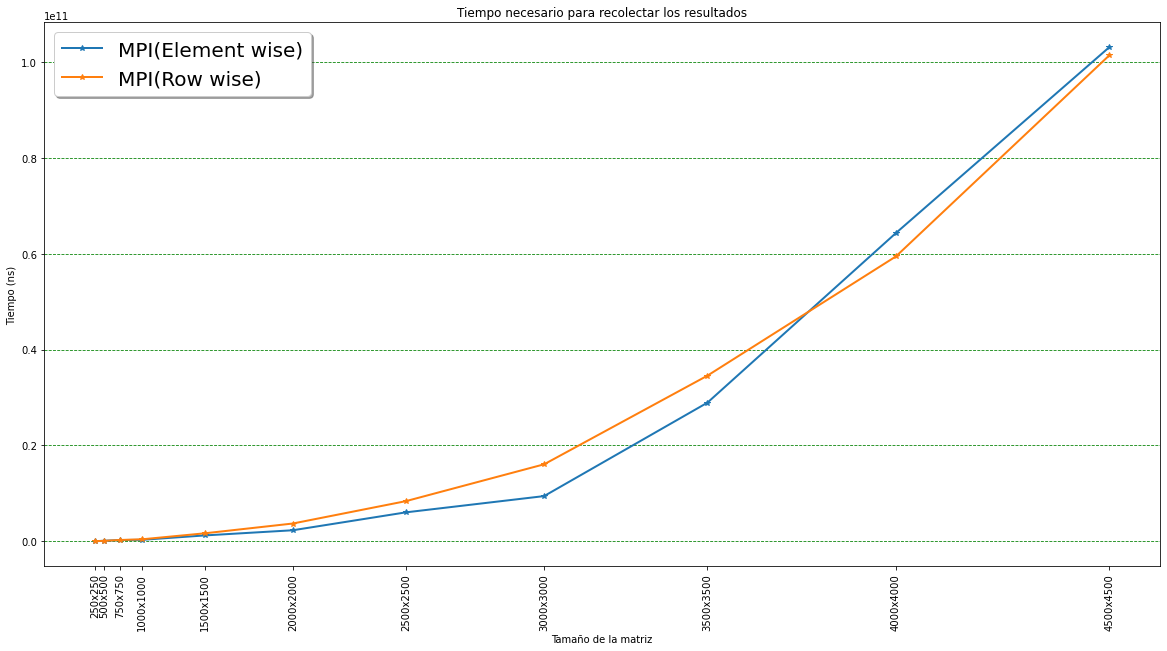

In [75]:
st = sr_gmean.loc["mpi", "Recv", "real_time_nsec"]
st_br = sr_gmean.loc["mpi_br", "Recv", "real_time_nsec"]

fig, ax = plt.subplots()
ax.plot(real_xaxis, st, '*-', label='MPI(Element wise)', linewidth=edgewidth)
ax.plot(real_xaxis, st_br, '*-', label='MPI(Row wise)', linewidth=edgewidth)

ax.set_title("Tiempo necesario para recolectar los resultados")
ax.set_ylabel("Tiempo (ns)")
ax.set_xlabel("Tamaño de la matriz")
ax.set_xticklabels(xlabel, rotation=90)
ax.set_xticks(real_xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)
ax.grid(color='green', linestyle = '--', axis='y')

fig.set_size_inches((20,10))

# NOT USEFULL

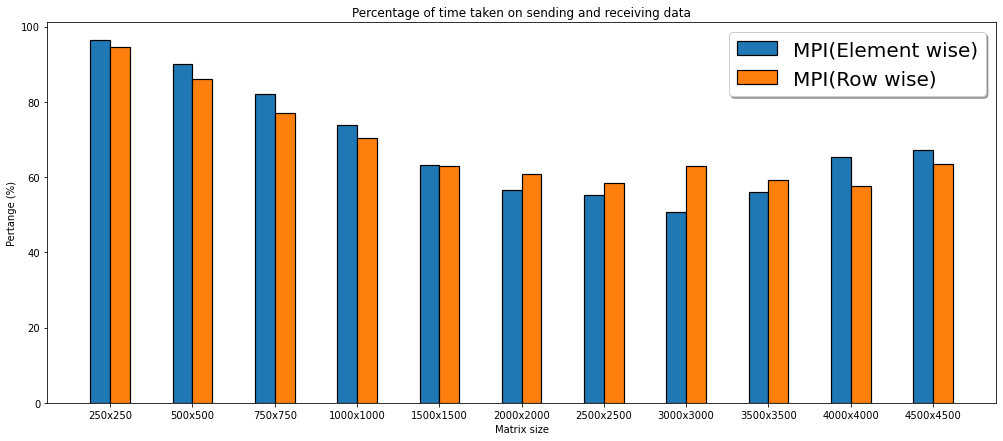

In [23]:
mpi_sr_time_per = 100*sr_gmean.loc["mpi", :, sr_gmean.index.get_level_values(2)=='real_time_nsec'].aggregate(sum) / gmean.loc["mpi", "real_time_nsec"]
mpi_br_sr_time_per = 100*sr_gmean.loc["mpi_br", :, sr_gmean.index.get_level_values(2)=='real_time_nsec'].aggregate(sum) / gmean.loc["mpi_br", "real_time_nsec"]


fig, ax = plt.subplots()
ax.bar(xaxis-width/2, mpi_sr_time_per, width, label='MPI(Element wise)',edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis+width/2, mpi_br_sr_time_per, width, label='MPI(Row wise)',edgecolor='black', linewidth=edgewidth)

ax.set_title("Percentage of time taken on sending and receiving data")
ax.set_ylabel("Pertange (%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)

fig.set_size_inches((17,7))

# TIME TAKEN TO COMPUTE, SEQUENTIAL: VERY USEFUL

1.1052053019058925

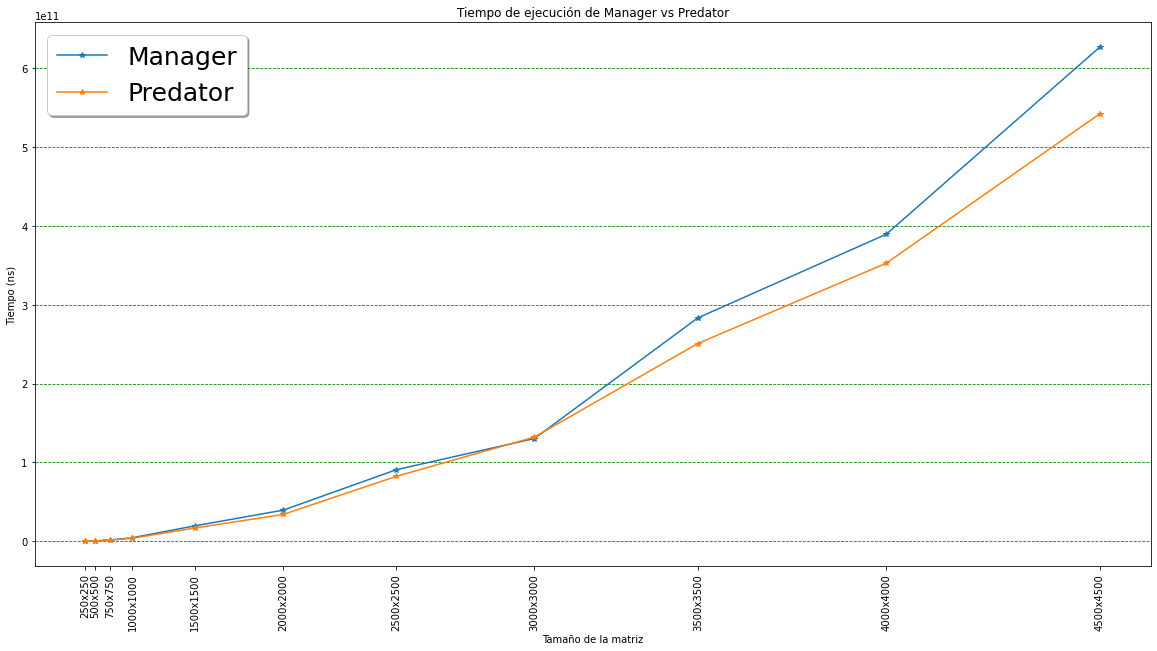

In [12]:
pr_time = pr_gmean.loc["real_time_nsec"]
pc_time = gmean.loc["seq", "real_time_nsec"]

fig, ax = plt.subplots()

ax.plot(real_xaxis, pc_time, '*-', label='Manager')
ax.plot(real_xaxis, pr_time, '*-', label='Predator')

ax.set_xticks(real_xaxis)
ax.set_xticklabels(xlabel, rotation=90)
ax.set_title("Tiempo de ejecución de Manager vs Predator")
ax.set_ylabel("Tiempo (ns)")
ax.set_xlabel("Tamaño de la matriz")
ax.legend(fontsize=25, shadow=True, fancybox=True)
ax.grid(color='green', linestyle = '--', axis='y')

fig.set_size_inches((20,10))

speed_ups = pc_time / pr_time
mean_speed_up = np.cumprod(speed_ups)[-1] ** (1/speed_ups.size)

mean_speed_up